In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import statsmodels.api as sm
import re

# Load environment variables
import os
from dotenv import load_dotenv
load_dotenv()


# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("tab10")

In [2]:
#Get the database URL from environment variables
DATABASE_URL = os.getenv('DATABASE_URL')

# Create a connection to the SQLite database
conn = psycopg2.connect(DATABASE_URL)

# Define the SQL query to get comprehensive dataset for analysis
all_data_query = """
SELECT 
    p.doi,
    p.figure_number,
    s.sandstone_name,
    dp.p_mpa,
    dp.q_mpa
FROM data_points dp
JOIN sandstones s ON dp.sandstone_id = s.id
JOIN plots p ON s.plot_id = p.id
ORDER BY p.doi, s.sandstone_name, dp.p_mpa
"""

In [3]:
# Convert the SQL query result into a DataFrame
df_all_data = pd.read_sql_query(all_data_query, conn)

# Display the DataFrame 
df_all_data

C:\Users\qmxj311\AppData\Local\Temp\ipykernel_51220\1571953894.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all_data = pd.read_sql_query(all_data_query, conn)


,doi,figure_number,sandstone_name,p_mpa,q_mpa
0,10.1007/BF00876528,4,"Blair Dolomite, Knox Dolomite, Solenhofen Lime...",53.806050,29.378788
1,10.1007/BF00876528,4,"Blair Dolomite, Knox Dolomite, Solenhofen Lime...",63.295097,38.075756
2,10.1007/BF00876528,4,"Blair Dolomite, Knox Dolomite, Solenhofen Lime...",74.139730,49.636364
3,10.1007/BF00876528,4,Dolomite,22.314910,5.939394
4,10.1007/BF00876528,4,Dolomite,22.314910,4.560606
...,...,...,...,...,...
262,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),237.942120,287.015930
263,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),246.945340,277.904330
264,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),271.382630,305.239170
265,10.1016/j.jsg.2012.08.014,8,Serpentinite (20%),285.530550,300.683380


In [4]:
# Filter for Rutter and Glover Figure 8 data
rut_glov_fig8 = df_all_data[df_all_data['doi'] == '10.1016/j.jsg.2012.08.014']

# Filter for friction data
friction_data = rut_glov_fig8[rut_glov_fig8['sandstone_name'] == 'Porous sandstone friction data']

# Remove Serpentinite data
rut_glov_fig8 = rut_glov_fig8[(rut_glov_fig8['sandstone_name'] != 'Serpentinite (20%)') & (rut_glov_fig8['sandstone_name'] != 'Porous sandstone friction data')]

## Recreating Rutter and Glover (2012) Figure 8

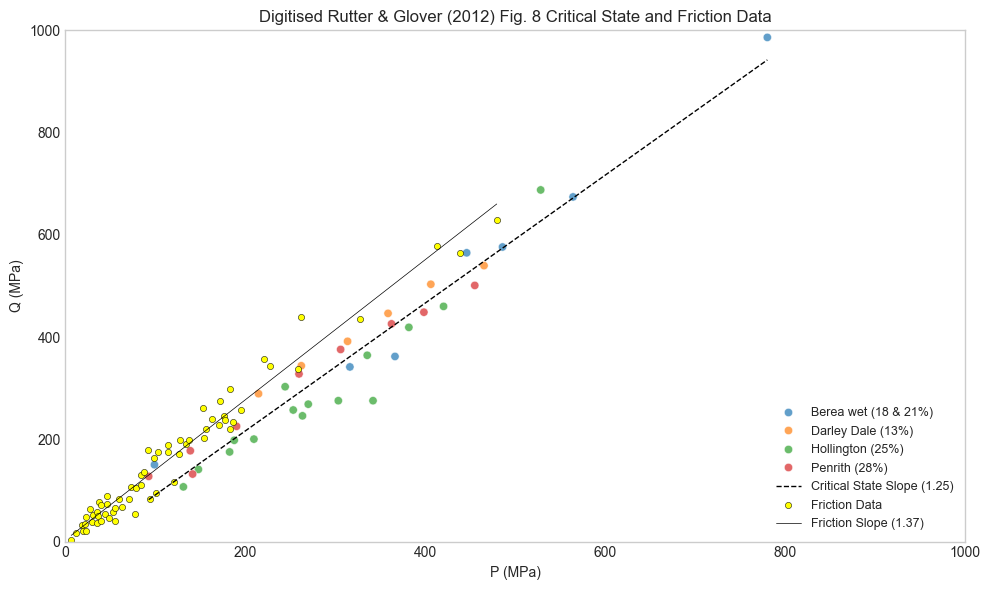

OLS Regression Results for Rutter & Glover Figure 8 Sandstone Data
                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     700.3
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           9.88e-25
Time:                        14:35:00   Log-Likelihood:                -189.07
No. Observations:                  37   AIC:                             382.1
Df Residuals:                      35   BIC:                             385.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [5]:
# --- Sandstone regression ---
X = sm.add_constant(rut_glov_fig8['p_mpa'])
y = rut_glov_fig8['q_mpa']
model = sm.OLS(y, X).fit()
slope_sandstone = model.params['p_mpa']

# --- Friction regression ---
friction_X = sm.add_constant(friction_data['p_mpa'])
friction_y = friction_data['q_mpa']
friction_model = sm.OLS(friction_y, friction_X).fit()
slope_friction = friction_model.params['p_mpa']

# --- Combined plot ---
plt.figure(figsize=(10, 6))

# Sandstone data + regression
sns.scatterplot(data=rut_glov_fig8, x='p_mpa', y='q_mpa', hue='sandstone_name', alpha=0.7)
sns.regplot(data=rut_glov_fig8, x='p_mpa', y='q_mpa', scatter=False,
            color='black', ci=None, line_kws={'linewidth': 1.0, 'linestyle': '--'},
            label=f"Critical State Slope ({slope_sandstone:.2f})")

# Friction data + regression
sns.scatterplot(data=friction_data, x='p_mpa', y='q_mpa', color='yellow', s=20, edgecolor='black', label='Friction Data')
sns.regplot(data=friction_data, x='p_mpa', y='q_mpa', scatter=False,
            color='black', ci=None, line_kws={'linewidth': 0.5, 'linestyle': '-'},
            label=f"Friction Slope ({slope_friction:.2f})")

plt.xlabel('P (MPa)', fontsize=10)
plt.ylabel('Q (MPa)', fontsize=10)
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.title('Digitised Rutter & Glover (2012) Fig. 8 Critical State and Friction Data')
plt.legend(loc='lower right', fontsize=9)
plt.grid(False)

plt.tight_layout()
plt.savefig("stats_plots/Rutter_Glover_2012_Fig8_Combined.png", dpi=600, bbox_inches='tight')
plt.show()

# Print regression summaries
print("OLS Regression Results for Rutter & Glover Figure 8 Sandstone Data")
print(model.summary())
print("\nOLS Regression Results for Rutter & Glover Figure 8 Friction Data")
print(friction_model.summary())


## Include Wong & Baud, 2012. Figures 5a,b and 6a,b (Limestones)

In [6]:
# Wong and Baud Data
wong_baud = df_all_data[df_all_data['doi'] == '10.1016/j.jsg.2012.07.010']

# Combine (Wong and Baud) sandstone data with (Rutter and Glover) sandstone data
wong_baud_fig5 = wong_baud[wong_baud['figure_number'].isin(['5a', '5b'])]

rutter_glover_wong_baud = pd.concat([rut_glov_fig8, wong_baud_fig5], ignore_index=True)

# Wong and Baud Limestone Data
wong_baud_limestone = wong_baud[wong_baud['figure_number'].isin(['6a', '6b'])]

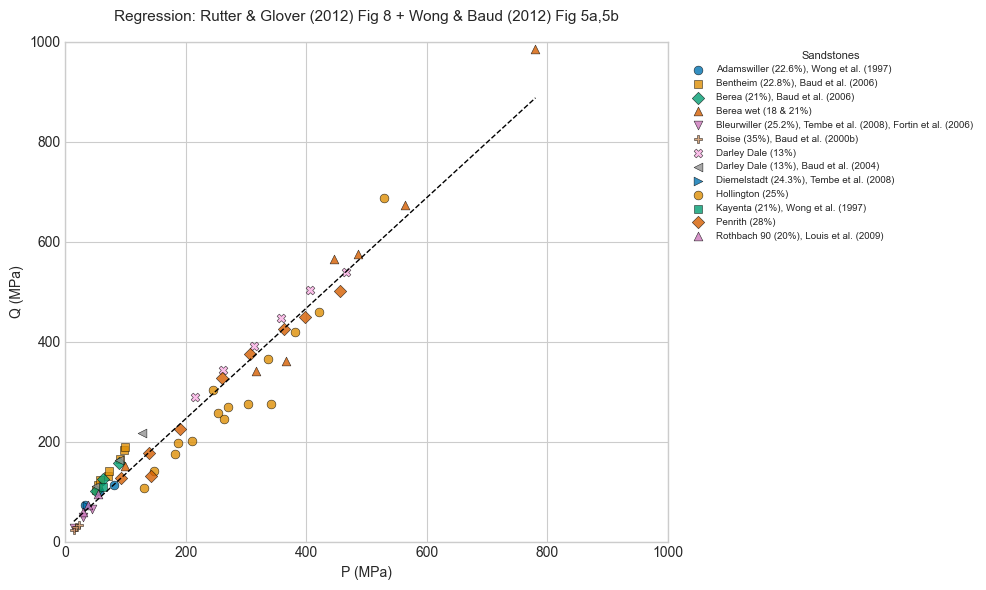

In [7]:
# Create a regression plot for new data including Wong and Baud, 2012 data

# Sort the sandstone names for consistent ordering
sandstones = sorted(rutter_glover_wong_baud['sandstone_name'].unique())
n_groups = len(sandstones)

# Pairing colors and markers
colors = sns.color_palette("colorblind", n_colors=min(n_groups, 8))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>'] 

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group separately
for i, name in enumerate(sandstones):
    group = rutter_glover_wong_baud[rutter_glover_wong_baud['sandstone_name'] == name]
    ax.scatter(
        group['p_mpa'], group['q_mpa'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )

# Regression line
sns.regplot(
    data=rutter_glover_wong_baud, x='p_mpa', y='q_mpa',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax
)

ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# Legend
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)

plt.title('Regression: Rutter & Glover (2012) Fig 8 + Wong & Baud (2012) Fig 5a,5b', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/RutterGlover, 2012_Fig8 & WongBaud_2012 Fig5a,b.png", dpi=600, bbox_inches='tight')
plt.show()


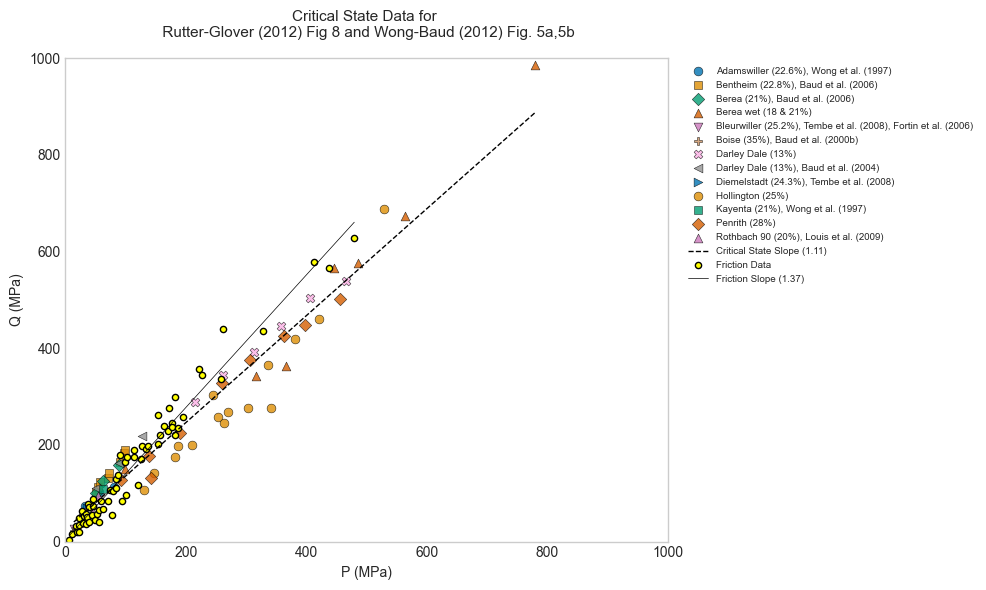


OLS Regression Results for Wong & Baud 2012 Sandstone Data
                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1368.
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.92e-44
Time:                        14:35:06   Log-Likelihood:                -331.84
No. Observations:                  65   AIC:                             667.7
Df Residuals:                      63   BIC:                             672.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [8]:
# --- Rutter & Glover and Wong & Baud 2012 regression ---
X_wb = sm.add_constant(rutter_glover_wong_baud['p_mpa'])
y_wb = rutter_glover_wong_baud['q_mpa']
wb_model = sm.OLS(y_wb, X_wb).fit()
slope_wb = wb_model.params['p_mpa']

# --- Combined plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Rutter & Glover sandstone groups
sandstones = sorted(rutter_glover_wong_baud['sandstone_name'].unique())
colors = sns.color_palette("colorblind", n_colors=min(len(sandstones), 8))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>']

for i, name in enumerate(sandstones):
    group = rutter_glover_wong_baud[rutter_glover_wong_baud['sandstone_name'] == name]
    ax.scatter(
        group['p_mpa'], group['q_mpa'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )

# Regression line for Wong & Baud combined dataset
sns.regplot(
    data=rutter_glover_wong_baud, x='p_mpa', y='q_mpa',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax,
    label=f"Critical State Slope ({slope_wb:.2f})"
)

# Add friction data
ax.scatter(
    friction_data['p_mpa'], friction_data['q_mpa'],
    color='yellow', s=20, edgecolor='black', label='Friction Data'
)
sns.regplot(
    data=friction_data, x='p_mpa', y='q_mpa',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 0.5, 'linestyle': '-'},
    ax=ax,
    label=f"Friction Slope ({slope_friction:.2f})"
)

# Axes and legend
ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, 
    title_fontsize=8, frameon=False, ncol=1
)
ax.grid(False)

plt.title('Critical State Data for \n Rutter-Glover (2012) Fig 8 and Wong-Baud (2012) Fig. 5a,5b', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/RutterGlover_WongBaud_Figures_Combined.png", dpi=600, bbox_inches='tight')
plt.show()

# Print regression summaries
print("\nOLS Regression Results for Wong & Baud 2012 Sandstone Data")
print(wb_model.summary())


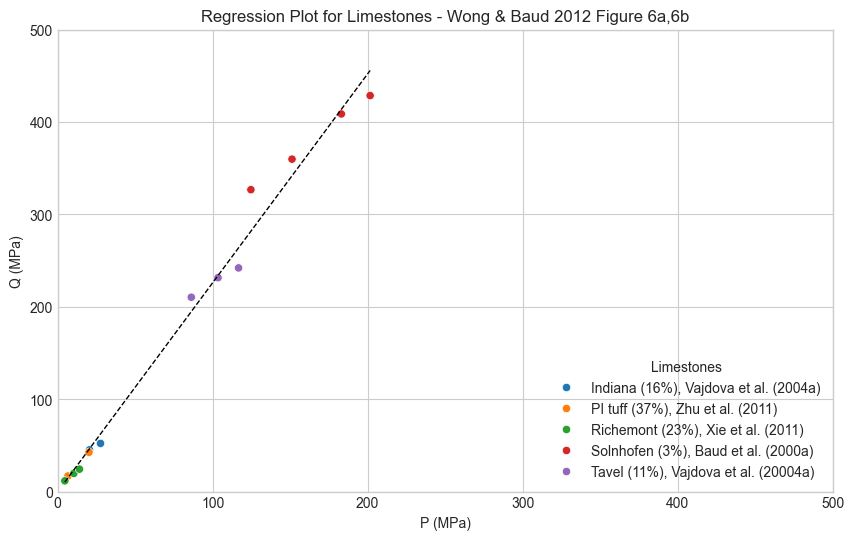

In [9]:
# Create a regression plot for limestones
plt.figure(figsize=(10, 6))
sns.scatterplot(data=wong_baud_limestone, x='p_mpa', y='q_mpa', hue='sandstone_name')
sns.regplot(data=wong_baud_limestone, x='p_mpa', y='q_mpa', scatter=False, 
            ci=None, line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'})
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel('P (MPa)')
plt.ylabel('Q (MPa)')
plt.legend(loc='lower right', title='Limestones')
plt.title('Regression Plot for Limestones - Wong & Baud 2012 Figure 6a,6b')
plt.savefig("stats_plots/Limestones WongBaud_2012 Fig6a,b.png", dpi=600, bbox_inches='tight')
plt.show()

In [10]:
# OLS Regression for limestones
X_limestone = wong_baud_limestone['p_mpa']
y_limestone = wong_baud_limestone['q_mpa']
X_limestone = sm.add_constant(X_limestone)  # Adds a constant term to the
model_limestone = sm.OLS(y_limestone, X_limestone).fit()
print(f" Wong & Baud Fig 6a,b \n{model_limestone.summary()}")

 Wong & Baud Fig 6a,b 
                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     983.5
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           6.96e-13
Time:                        14:35:08   Log-Likelihood:                -59.475
No. Observations:                  14   AIC:                             122.9
Df Residuals:                      12   BIC:                             124.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1381      7.

c:\Users\qmxj311\AppData\Local\anaconda3\envs\env\lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=14 observations were given.
  return hypotest_fun_in(*args, **kwds)


## Limestone Friction Data - Byerlee, 1978. Figure 4

In [11]:
# filter for limestone friction data
limestone_friction_data = df_all_data[df_all_data['doi'] == '10.1007/BF00876528']

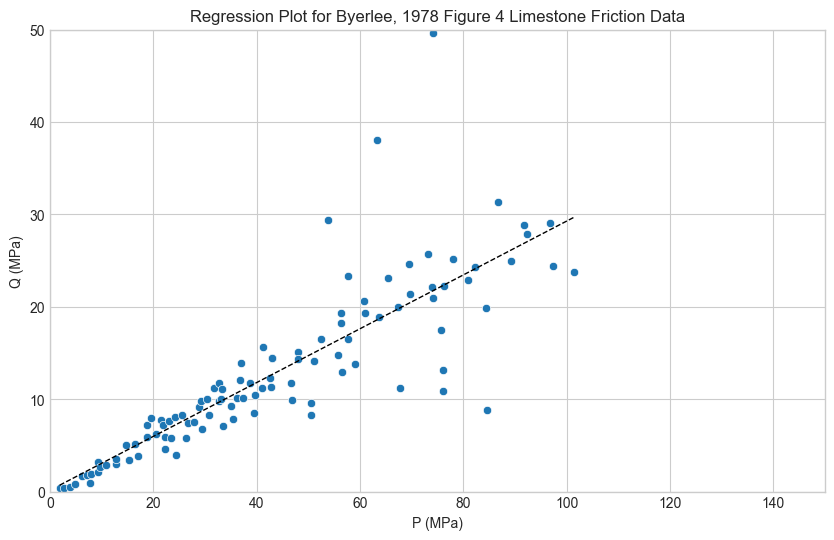

OLS Regression Results for Byerlee, 1978 Figure 4 Limestone Friction Data 

                            OLS Regression Results                            
Dep. Variable:                  q_mpa   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     254.1
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.45e-29
Time:                        14:35:10   Log-Likelihood:                -312.95
No. Observations:                 105   AIC:                             629.9
Df Residuals:                     103   BIC:                             635.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [12]:
# Create a regression plot for the friction data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=limestone_friction_data, x='p_mpa', y='q_mpa')
sns.regplot(data=limestone_friction_data, x='p_mpa', y='q_mpa', scatter=False, 
            color='black', ci=None, label='Regression Line', 
            line_kws={'linewidth': 1.0, 'linestyle': '--'})
plt.xlim(0, 150)
plt.ylim(0, 50)
plt.xlabel('P (MPa)', fontsize=10)
plt.ylabel('Q (MPa)', fontsize=10)
plt.title('Regression Plot for Byerlee, 1978 Figure 4 Limestone Friction Data')
plt.savefig("stats_plots/Byerlee_1978_Fig4_FrictionData.png", dpi=600, bbox_inches='tight')
plt.show()

# OLS for friction data
friction_X = limestone_friction_data['p_mpa']
friction_y = limestone_friction_data['q_mpa']
friction_X = sm.add_constant(friction_X)  # Adds a constant term to the predictor
limestone_friction_model = sm.OLS(friction_y, friction_X).fit()
print(f"OLS Regression Results for Byerlee, 1978 Figure 4 Limestone Friction Data \n")
print(limestone_friction_model.summary())

_____
## Can We Estimate Rock Strength Using Porosity and Grain Size?

In [13]:
# Grain size of sandstones in Rutter and Glover, 2012
grain_sizes = {
    'Darley Dale (13%)': 171,
    'Berea wet (18 & 21%)' : 170,
    'Hollington (25%)': 230,
    'Penrith (28%)': 129.6
}

# Extract Porosity of the Sandstones
def extract_porosity(s):
    """
    Extracts the porosity percentage from a string formatted like "(x%)"
    """
    matches = re.findall(r"(\d+(?:\.\d+)?)%", s)
    return float(matches[0]) if matches else None
    
# Apply the function to the 'sandstone_name' column
rut_glov_fig8['porosity'] = rut_glov_fig8['sandstone_name'].apply(extract_porosity)

# Create a DataFrame to include porosity and grain size
rutter_glover_with_por_gsize = pd.DataFrame({
    'Sandstone': rut_glov_fig8['sandstone_name'],
    'P (MPa)': rut_glov_fig8['p_mpa'],
    'Q (MPa)': rut_glov_fig8['q_mpa'],
    'Porosity (%)': rut_glov_fig8['porosity'],
    'Grain Size (mm)': [grain_sizes.get(name, None) for name in rut_glov_fig8['sandstone_name']]
})
# Display the porosity and grain size DataFrame
rutter_glover_with_por_gsize.head()

,Sandstone,P (MPa),Q (MPa),Porosity (%),Grain Size (mm)
147,Berea wet (18 & 21%),99.03537,150.34169,21.0,170.0
148,Berea wet (18 & 21%),316.39870,341.68564,21.0,170.0
149,Berea wet (18 & 21%),366.55948,362.18680,21.0,170.0
150,Berea wet (18 & 21%),446.30225,564.92030,21.0,170.0
151,Berea wet (18 & 21%),486.17365,576.30980,21.0,170.0


In [14]:
# Define function to calculate the hydrostatic pressure P*
def hydrostatic_pressure(porosity, grain_size_µm):
    """
    Calculate the hydrostatic pressure P* based on porosity (%) and grain size (µm).

    Equation:
    log10(P*) [MPa] = 0.625 - 1.064 * log10(porosity_decimal * grain_size_mm)

    Parameters
    ----------
    porosity : float
        Porosity in percent (%).
    grain_size_um : float
        Grain size in micrometres (µm).

    Returns
    -------
    float
        Hydrostatic pressure P* in MPa.
    """
    if porosity is None or grain_size_µm is None:
        return None

    porosity_decimal = porosity / 100
    grain_size_mm = grain_size_µm / 1000.0   # convert µm → mm

    fr_mm = porosity_decimal * grain_size_mm
    log10_P = 0.625 - 1.064 * np.log10(fr_mm)
    return 10 ** log10_P


# Apply the hydrostatic pressure function to the DataFrame
rutter_glover_with_por_gsize['P* (MPa)'] = rutter_glover_with_por_gsize.apply(
    lambda row: hydrostatic_pressure(row['Porosity (%)'], row['Grain Size (mm)']), axis=1
)
# Display the DataFrame with hydrostatic pressure
rutter_glover_with_por_gsize.tail()


,Sandstone,P (MPa),Q (MPa),Porosity (%),Grain Size (mm),P* (MPa)
179,Penrith (28%),259.80707,328.01822,28.0,129.6,143.685232
180,Penrith (28%),306.10930,375.85422,28.0,129.6,143.685232
181,Penrith (28%),362.70096,425.96810,28.0,129.6,143.685232
182,Penrith (28%),398.71384,448.74716,28.0,129.6,143.685232
183,Penrith (28%),455.30548,501.13895,28.0,129.6,143.685232


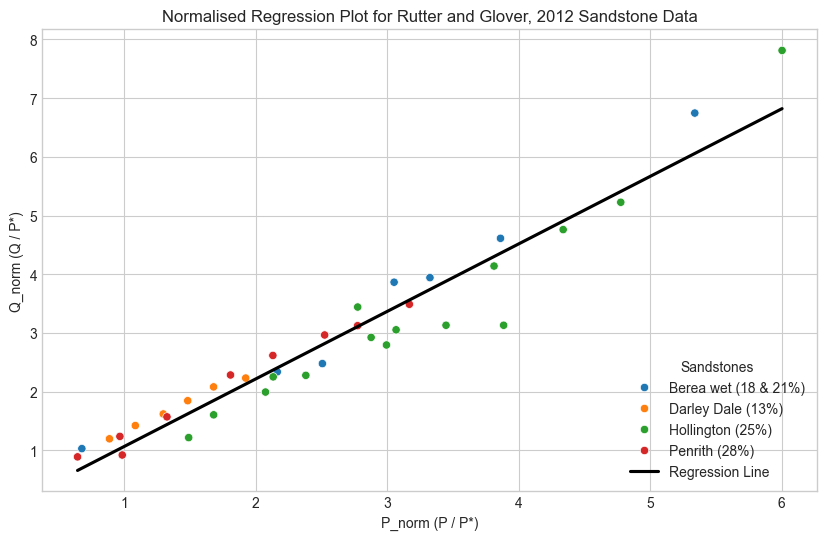

OLS Regression Results for Normalised Rutter and Glover, 2012 Sandstone Data 

                            OLS Regression Results                            
Dep. Variable:                 Q_norm   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     476.8
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           5.66e-22
Time:                        14:35:12   Log-Likelihood:                -18.679
No. Observations:                  37   AIC:                             41.36
Df Residuals:                      35   BIC:                             44.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [15]:
# Normalise P and Q values by diving by the hydrostatic pressure P*
rutter_glover_with_por_gsize['P_norm'] = rutter_glover_with_por_gsize['P (MPa)'] / rutter_glover_with_por_gsize['P* (MPa)']
rutter_glover_with_por_gsize['Q_norm'] = rutter_glover_with_por_gsize['Q (MPa)'] / rutter_glover_with_por_gsize['P* (MPa)']

# Create a regression plot for the normalised data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rutter_glover_with_por_gsize, x='P_norm', y='Q_norm', hue='Sandstone')
sns.regplot(data=rutter_glover_with_por_gsize, x='P_norm', y='Q_norm', scatter=False, 
            color='black', ci=None, label='Regression Line')
plt.xlabel('P_norm (P / P*)', fontsize=10)
plt.ylabel('Q_norm (Q / P*)', fontsize=10)
plt.title('Normalised Regression Plot for Rutter and Glover, 2012 Sandstone Data')
plt.legend(loc='lower right', title='Sandstones')
plt.savefig("stats_plots/Rutter_Glover_2012_Normalised_P_Q.png",
           dpi=600, bbox_inches='tight')
plt.show()
# OLS Regression for normalised data
X_norm = rutter_glover_with_por_gsize['P_norm']
y_norm = rutter_glover_with_por_gsize['Q_norm']
X_norm = sm.add_constant(X_norm)  # Adds a constant term to the predictor
model_norm = sm.OLS(y_norm, X_norm).fit()
print(f"OLS Regression Results for Normalised Rutter and Glover, 2012 Sandstone Data \n")
print(model_norm.summary())


In [16]:
rutter_glover_with_por_gsize[rutter_glover_with_por_gsize['Sandstone'] == 'Hollington (25%)']

,Sandstone,P (MPa),Q (MPa),Porosity (%),Grain Size (mm),P* (MPa),P_norm,Q_norm
160,Hollington (25%),131.18971,107.06150,25.0,230.0,88.046767,1.490000,1.215962
161,Hollington (25%),147.90997,141.23007,25.0,230.0,88.046767,1.679902,1.604035
162,Hollington (25%),182.63666,175.39864,25.0,230.0,88.046767,2.074314,1.992108
163,Hollington (25%),187.78136,198.17767,25.0,230.0,88.046767,2.132746,2.250823
164,Hollington (25%),209.64630,200.45558,25.0,230.0,88.046767,2.381079,2.276694
165,Hollington (25%),244.37299,302.96127,25.0,230.0,88.046767,2.775491,3.440913
166,Hollington (25%),253.37620,257.40320,25.0,230.0,88.046767,2.877746,2.923483
167,Hollington (25%),263.66560,246.01367,25.0,230.0,88.046767,2.994609,2.794125
168,Hollington (25%),270.09647,268.79272,25.0,230.0,88.046767,3.067648,3.052840
169,Hollington (25%),303.53700,275.62643,25.0,230.0,88.046767,3.447452,3.130455


_______
## Include Additional Sandstones from Wong & Baud

In [17]:
# Grain size of sandstones in Rutter and Glover, 2012
grain_sizes_wong_baud = {
    'Adamswiller (22.6%), Wong et al. (1997)': 90,
    'Bentheim (22.8%), Baud et al. (2006)' : 105,
    'Berea (21%), Baud et al. (2006)': 130,
    'Bleurwiller (25.2%), Tembe et al. (2008), Fortin et al. (2006)': 112,
    'Boise (35%), Baud et al. (2000b)': 280,
    'Darley Dale (13%), Baud et al. (2004)': 170,
    'Diemelstadt (24.3%), Tembe et al. (2008)': 80,
    'Kayenta (21%), Wong et al. (1997)': 150,
    'Rothbach 90 (20%), Louis et al. (2009)': 230,
    'Darley Dale (13%)': 171,
    'Berea wet (18 & 21%)' : 170,
    'Hollington (25%)': 230,
    'Penrith (28%)': 129.6
}
    
# Apply the function to the 'sandstone_name' column
rutter_glover_wong_baud['porosity'] = rutter_glover_wong_baud['sandstone_name'].apply(extract_porosity)

# Create a DataFrame to include porosity and grain size
rutter_glover_wong_baud_with_por_gsize = pd.DataFrame({
    'Sandstone': rutter_glover_wong_baud['sandstone_name'],
    'P (MPa)': rutter_glover_wong_baud['p_mpa'],
    'Q (MPa)': rutter_glover_wong_baud['q_mpa'],
    'Porosity (%)': rutter_glover_wong_baud['porosity'],
    'Grain Size (mm)': [grain_sizes_wong_baud.get(name, None) for name in rutter_glover_wong_baud['sandstone_name']]
})
# Display the porosity and grain size DataFrame
rutter_glover_wong_baud_with_por_gsize.head()

,Sandstone,P (MPa),Q (MPa),Porosity (%),Grain Size (mm)
0,Berea wet (18 & 21%),99.03537,150.34169,21.0,170.0
1,Berea wet (18 & 21%),316.39870,341.68564,21.0,170.0
2,Berea wet (18 & 21%),366.55948,362.18680,21.0,170.0
3,Berea wet (18 & 21%),446.30225,564.92030,21.0,170.0
4,Berea wet (18 & 21%),486.17365,576.30980,21.0,170.0


In [18]:
# Apply the hydrostatic pressure function to the DataFrame
rutter_glover_wong_baud_with_por_gsize['P* (MPa)'] = rutter_glover_wong_baud_with_por_gsize.apply(
    lambda row: hydrostatic_pressure(row['Porosity (%)'], row['Grain Size (mm)']), axis=1
)

# Normalise P and Q values by diving by the hydrostatic pressure P*
rutter_glover_wong_baud_with_por_gsize['P_norm'] = rutter_glover_wong_baud_with_por_gsize['P (MPa)'] / rutter_glover_wong_baud_with_por_gsize['P* (MPa)']
rutter_glover_wong_baud_with_por_gsize['Q_norm'] = rutter_glover_wong_baud_with_por_gsize['Q (MPa)'] / rutter_glover_wong_baud_with_por_gsize['P* (MPa)']

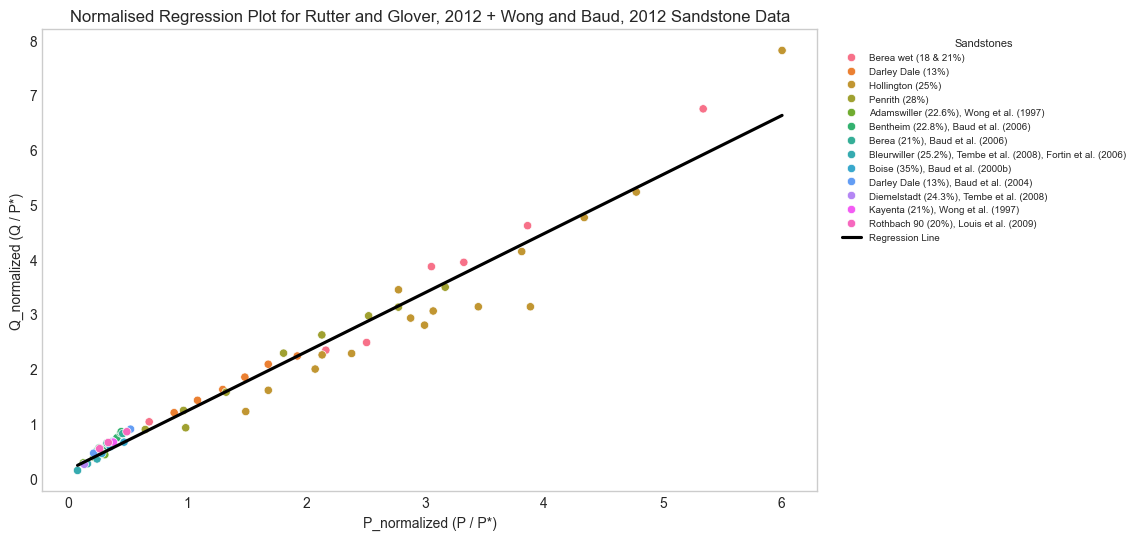

OLS Regression Results for Normalised Rutter and Glover, 2012 + Wong and Baud, 2012 Sandstone Data 

                            OLS Regression Results                            
Dep. Variable:                 Q_norm   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1520.
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           7.97e-46
Time:                        15:32:28   Log-Likelihood:                -18.583
No. Observations:                  65   AIC:                             41.17
Df Residuals:                      63   BIC:                             45.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [26]:
# Create a regression plot for the normalised data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rutter_glover_wong_baud_with_por_gsize, x='P_norm', y='Q_norm', hue='Sandstone')
sns.regplot(data=rutter_glover_wong_baud_with_por_gsize, x='P_norm', y='Q_norm', scatter=False, 
            color='black', ci=None, label='Regression Line')
plt.xlabel('P_normalized (P / P*)', fontsize=10)
plt.ylabel('Q_normalized (Q / P*)', fontsize=10)
plt.grid(False)
plt.title('Normalised Regression Plot for Rutter and Glover, 2012 + Wong and Baud, 2012 Sandstone Data')
plt.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)
plt.savefig("stats_plots/RutterGlover_WongBaud_Normalised_P_Q.png",
           dpi=600, bbox_inches='tight')
plt.show()
# OLS Regression for normalised data
X_norm_wong_baud = rutter_glover_wong_baud_with_por_gsize['P_norm']
y_norm_wong_baud = rutter_glover_wong_baud_with_por_gsize['Q_norm']
X_norm_wong_baud = sm.add_constant(X_norm_wong_baud)  # Adds a constant term to the predictor
model_norm_wong_baud = sm.OLS(y_norm_wong_baud, X_norm_wong_baud).fit()
print(f"OLS Regression Results for Normalised Rutter and Glover, 2012 + Wong and Baud, 2012 Sandstone Data \n")
print(model_norm_wong_baud.summary())



________

In [20]:
rutter_glover_wong_baud_with_por_gsize['Porosity (%)'].unique()

array([21. , 13. , 25. , 28. , 22.6, 22.8, 25.2, 35. , 24.3, 20. ])

# Different Porosoity Plots

In [21]:
# Split data based on median porosity

median_porosity = rutter_glover_wong_baud_with_por_gsize['Porosity (%)'].median()

# Dataframes for porosity below and above median
below_median = rutter_glover_wong_baud_with_por_gsize[rutter_glover_wong_baud_with_por_gsize['Porosity (%)'] < median_porosity]
above_median = rutter_glover_wong_baud_with_por_gsize[rutter_glover_wong_baud_with_por_gsize['Porosity (%)'] >= median_porosity]

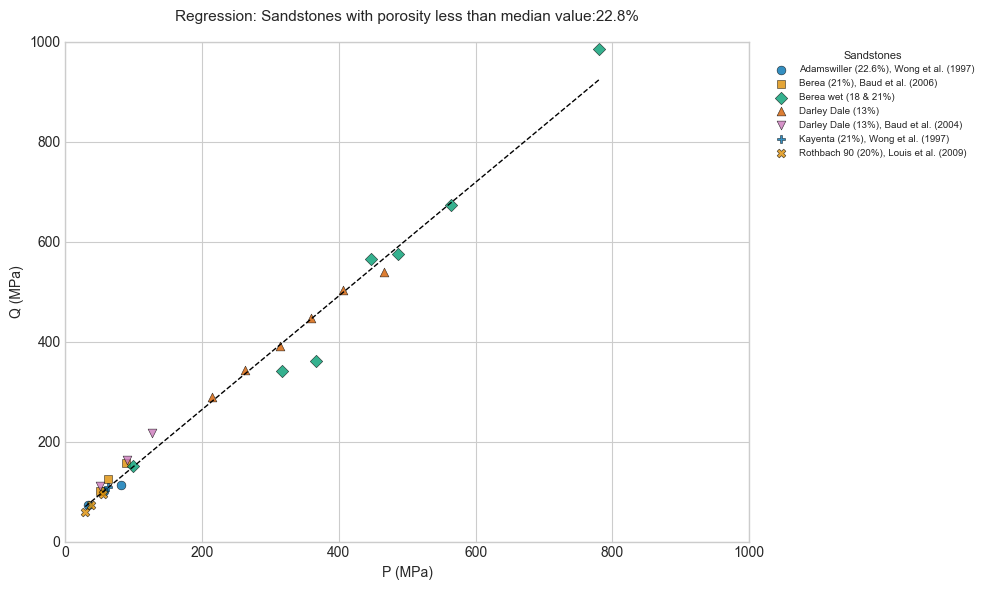

In [22]:
# Sort the sandstone names for consistent ordering
sandstones_below = sorted(below_median['Sandstone'].unique())
n_groups = len(sandstones_below)

# Pairing colors and markers
colors = sns.color_palette("colorblind", n_colors=min(n_groups, 5))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>'] 

fig, ax = plt.subplots(figsize=(10, 6))
for i, name in enumerate(sandstones_below):
    group = below_median[below_median['Sandstone'] == name]
    ax.scatter(
        group['P (MPa)'], group['Q (MPa)'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )
sns.regplot(
    data=below_median, x='P (MPa)', y='Q (MPa)',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax
)
ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# Legend
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)

plt.title(f'Regression: Sandstones with porosity less than median value:{median_porosity}%', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/porosity less than 22.8.png", dpi=600, bbox_inches='tight')
plt.show()

In [23]:
# OLS Regression for below median porosity
X_below = below_median['P (MPa)']
y_below = below_median['Q (MPa)']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor
model_below = sm.OLS(y_below, X_below).fit()
print(f"Regression Stats for Sandstones less than 22.8: \n{model_below.summary()}")

Regression Stats for Sandstones less than 22.8: 
                            OLS Regression Results                            
Dep. Variable:                Q (MPa)   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1631.
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.40e-23
Time:                        14:35:17   Log-Likelihood:                -123.29
No. Observations:                  26   AIC:                             250.6
Df Residuals:                      24   BIC:                             253.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

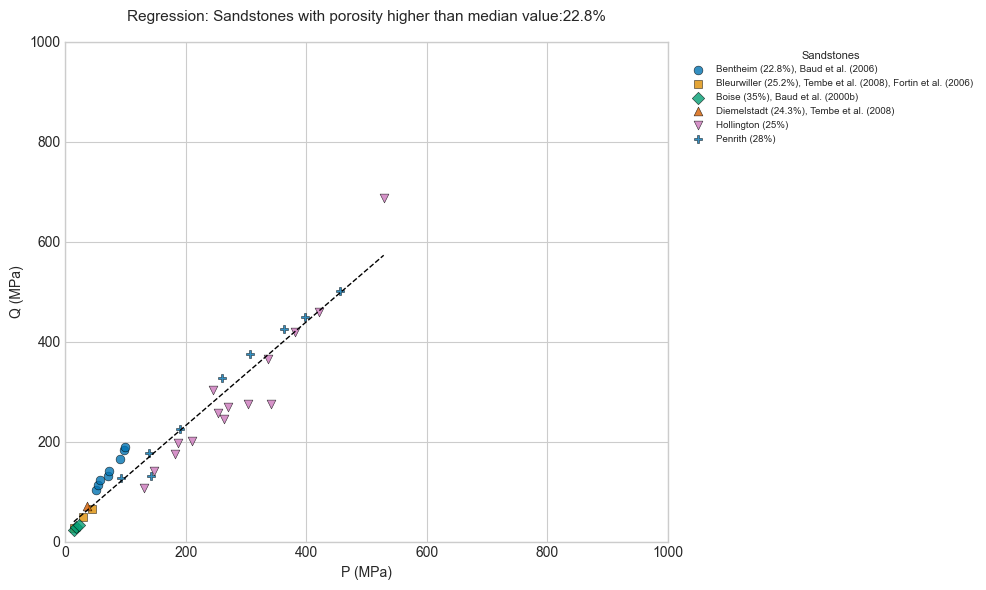

In [24]:
# Sort the sandstone names for consistent ordering
sandstones_above = sorted(above_median['Sandstone'].unique())
n_groups = len(sandstones_above)

# Pairing colors and markers
colors = sns.color_palette("colorblind", n_colors=min(n_groups, 5))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '<', '>'] 

fig, ax = plt.subplots(figsize=(10, 6))
for i, name in enumerate(sandstones_above):
    group = above_median[above_median['Sandstone'] == name]
    ax.scatter(
        group['P (MPa)'], group['Q (MPa)'],
        label=name,
        color=colors[i % len(colors)],
        marker=markers[i % len(markers)],
        edgecolor='black',
        linewidth=0.4,
        s=40,
        alpha=0.8
    )
sns.regplot(
    data=above_median, x='P (MPa)', y='Q (MPa)',
    scatter=False, ci=None,
    line_kws={'color': 'black', 'linewidth': 1.0, 'linestyle': '--'},
    ax=ax
)
ax.set_xlabel('P (MPa)', fontsize=10)
ax.set_ylabel('Q (MPa)', fontsize=10)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 1000)

# Legend
ax.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    fontsize=7, title='Sandstones',
    title_fontsize=8, frameon=False, ncol=1
)

plt.title(f'Regression: Sandstones with porosity higher than median value:{median_porosity}%', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig("stats_plots/porosity more than 22.8.png", dpi=600, bbox_inches='tight')
plt.show()



In [25]:
# OLS Regression for above median porosity
X_above = above_median['P (MPa)']
y_above = above_median['Q (MPa)']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor
model_above = sm.OLS(y_above, X_above).fit()
print(f"Regression Stats for Sandstones higher than 22.8: \n{model_above.summary()}")

Regression Stats for Sandstones higher than 22.8: 
                            OLS Regression Results                            
Dep. Variable:                Q (MPa)   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     482.2
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           8.10e-23
Time:                        14:35:20   Log-Likelihood:                -199.35
No. Observations:                  39   AIC:                             402.7
Df Residuals:                      37   BIC:                             406.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c